### Image Captioning - [article](https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8), [notebook](https://github.com/hlamba28/Automatic-Image-Captioning/blob/master/Automatic%20Image%20Captioning.ipynb), [article 2](https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/)

In [0]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!mkdir dataset
!unzip Flickr8k_Dataset.zip -d dataset
!unzip Flickr8k_text.zip -d dataset
!ls dataset

# Contents of dataset/
#
# Flicker8k_Dataset - directory containing all 8000 .jpg images
#
# Flickr8k.token.txt - the raw captions of the complete set of 8000 images in the Flickr8k Dataset 
# The first column is the ID of the caption which is "image address # caption number"
# Thus every line contains the <image name>#i <caption>, where 0≤i≤4
#    1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
#    1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
#    1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
#    1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
#    1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
#    1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
#    1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
#    1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
#
# Flickr8k.lemma.txt - the lemmatized version of the above captions 
#
# Flickr_8k.trainImages.txt - The subset of images to be used as the training set (6000 images)
#    2513260012_03d33305cf.jpg
#    2903617548_d3e38d7f88.jpg
#    3338291921_fe7ae0c8f8.jpg
#    488416045_1c6d903fe0.jpg
#
# Flickr_8k.devImages.txt - The subset of images to be used as the validation set (1000 images)
# Flickr_8k.testImages.txt - The subset of images to be used as the test set (1000 images)

In [0]:
import numpy as np
from numpy import array
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#--------------------------------------------------
# load the file containing all of the captions into a single long string
#--------------------------------------------------
caption_file = "dataset/Flickr8k.token.txt"
def load_captions (filename):
  with open(filename, "r") as fp:
    # Read all text in the file
    text = fp.read()
    return (text)

doc = load_captions (caption_file)
  
len(doc), '\n', doc [:200]

(3395237,
 '\n',
 '1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n1000268201_693b08cb0e.jpg#2\tA lit')

In [0]:
#--------------------------------------------------
# Each photo has a unique identifier, which is the file name of the image .jpg file
# Create a dictionary of photo identifiers (without the .jpg) to captions. Each photo identifier maps to
# a list of one or more textual descriptions.
#
# {"image_name_1" : ["caption 1", "caption 2", "caption 3"],
#  "image_name_2" : ["caption 4", "caption 5"]}
#--------------------------------------------------
def captions_dict (text):
  dict = {}
  
  # Make a List of each line in the file
  lines = text.split ('\n')
  for line in lines:
    
    # Split into the <image_data> and <caption>
    line_split = line.split ('\t')
    if (len(line_split) != 2):
      # Added this check because dataset contains some blank lines
      continue
    else:
      image_data, caption = line_split

    # Split into <image_file> and <caption_idx>
    image_file, caption_idx = image_data.split ('#')
    # Split the <image_file> into <image_name>.jpg
    image_name = image_file.split ('.')[0]
    
    # If this is the first caption for this image, create a new list for that
    # image and add the caption to it. Otherwise append the caption to the 
    # existing list
    if (int(caption_idx) == 0):
      dict [image_name] = [caption]
    else:
      dict [image_name].append (caption)
  
  return (dict)
    
image_dict = captions_dict (doc)
len (image_dict)

8092

In [0]:
#--------------------------------------------------
# Clean the captions data
#    Convert all words to lowercase.
#    Remove all punctuation.
#    Remove all words that are one character or less in length (e.g. ‘a’).
#    Remove all words with numbers in them.
#--------------------------------------------------
import re
def captions_clean (image_dict):
  # <key> is the image_name, which can be ignored
  for key, captions in image_dict.items():
    
    # Loop through each caption for this image
    for i, caption in enumerate (captions):
      
      # Convert the caption to lowercase, and then remove all special characters from it
      caption_nopunct = re.sub(r"[^a-zA-Z0-9]+", ' ', caption.lower())
      
      # Split the caption into separate words, and collect all words which are more than 
      # one character and which contain only alphabets (ie. discard words with mixed alpha-numerics)
      clean_words = [word for word in caption_nopunct.split() if ((len(word) > 1) and (word.isalpha()))]
      
      # Join those words into a string
      caption_new = ' '.join(clean_words)
      
      # Replace the old caption in the captions list with this new cleaned caption
      captions[i] = caption_new
      
captions_clean (image_dict)
len (image_dict), list (image_dict.items())[100]

(8092,
 ('1110208841_5bb6806afe',
  ['black and white border collie catches frisbee in front of an audience',
   'brown and white dog catches frisbee in it mouth in front of group of people',
   'brown and white dug jumping up to catch frisbee while an audience watches',
   'dog jumps to catch frisbee while many people watch',
   'an agile dog catches frisbee while crowd of onlookers watches closely']))

In [0]:
#--------------------------------------------------
# Build a vocabulary as a list of unique words, from all the words in the corpus
#--------------------------------------------------
def build_vocab (image_dict):
  word_set = set()
  for key, captions in image_dict.items():
    for caption in captions:
      # Split each caption into separate words and add them to the set
      # Since it's a set, any duplicate words get discarded
      word_set.update(caption.split())
  return (sorted (list(word_set)))
      
vocab = build_vocab(image_dict)
len (vocab), vocab [:10]

(8422,
 ['abandon',
  'abandoned',
  'abarrotes',
  'abdomen',
  'ability',
  'aboard',
  'aboriginal',
  'about',
  'above',
  'abs'])

In [0]:
#--------------------------------------------------
# We have three separate files which contain the names for the subset of 
# images to be used for training, validation or testing respectively
#
# Given a file, we return a set of image names (without .jpg extension) in that file
#--------------------------------------------------
def subset_image_name (filename):
  data = []
  
  with open(filename, "r") as fp:
    # Read all text in the file
    text = fp.read()
  
    # Make a List of each line in the file
    lines = text.split ('\n')
    for line in lines:
      # skip empty lines
      if (len(line) < 1):
        continue
      
      # Each line is the <image_file>
      # Split the <image_file> into <image_name>.jpg
      image_name = line.split ('.')[0]
      
      # Add the <image_name> to the list
      data.append (image_name)

    return (set(data))  

training_image_name_file = "dataset/Flickr_8k.trainImages.txt"
training_image_names = subset_image_name (training_image_name_file)
len (training_image_names), list (training_image_names) [:10]

(6000,
 ['429283612_37f6e7fb7f',
  '2660480624_45f88b3022',
  '3601508034_5a3bfc905e',
  '383223174_7165a54c30',
  '3565749152_7924d15b04',
  '2719102611_fef453bf30',
  '2390369143_6523253a73',
  '3119887967_271a097464',
  '3465000218_c94e54e208',
  '3304712466_18cbdb85fe'])

In [0]:
#--------------------------------------------------
# Add two tokens, 'startseq' and 'endseq' at the beginning and end respectively, 
# of every caption
#
# The model we will develop will generate a caption given a photo, and the caption will 
# be generated one word at a time. The sequence of previously generated words will 
# be provided as input. Therefore, we will need a ‘first word’ to kick-off the generation 
# process and a ‘last word‘ to signal the end of the caption.
#--------------------------------------------------
def add_token (captions):
  for i, caption in enumerate (captions):
    captions[i] = 'startseq ' + caption + ' endseq'
  return (captions)

#--------------------------------------------------
# Given a set of training, validation or testing image names, return a dictionary
# containing the corresponding subset from the full dictionary of images with captions
#
# This returned subset has the same structure as the full dictionary
# {"image_name_1" : ["caption 1", "caption 2", "caption 3"],
#  "image_name_2" : ["caption 4", "caption 5"]}
#--------------------------------------------------
def subset_data_dict (image_dict, image_names):
  dict = { image_name:add_token(captions) for image_name,captions in image_dict.items() if image_name in image_names}
  return (dict)
  
training_dict = subset_data_dict (image_dict, training_image_names)
len (training_dict), training_dict ['3326024473_4c16e4fbfc']

(6000,
 ['startseq yellow car drives across snowy path endseq',
  'startseq yellow car drives quickly in the snow endseq',
  'startseq yellow car driving through lot of snow endseq',
  'startseq yellow car is drifting through snow endseq',
  'startseq yellow car speeds along snowy field endseq'])

In [0]:
#--------------------------------------------------
# Pre-process our images
# Pre-compute the “photo features” for each image by Transfer Learning using a pre-trained 
# model and save them to file. We can then load these features later and feed them into our 
# model as the representation of a given photo in the dataset.
#
# We can load the InceptionV3 model in Keras. We remove the last softmax classification layer 
# from the loaded model, as this is the model used to predict a classification for a photo. We 
# are not interested in classifying images, but we are interested in the internal representation 
# of the photo right before a classification is made. These are the “features” that the model 
# has extracted from the photo. In the case of Inception, these image features are a 
# 1-dimensional 2048-element vector.
#
# Keras also provides tools for reshaping the loaded photo into the preferred size for the model
#--------------------------------------------------
def process_image (model, image_path):
  
  # Convert all the images to size 299x299 as expected by the inception v3 model
  img = image.load_img(image_path, target_size=(299, 299))
  # Convert PIL image to numpy array of 3-dimensions
  x = image.img_to_array(img)
  # Add one more dimension
  x = np.expand_dims(x, axis=0)
  # preprocess the images using preprocess_input() from inception module
  x = preprocess_input(x)

  feature = model.predict(x) # Get the encoding vector for the image
  feature = np.reshape(feature, feature.shape[1]) # reshape from (1, 2048) to (2048, )

  return (feature)

#--------------------------------------------------
# Load the Pre-trained Image Classification model to be used for transfer learning
#--------------------------------------------------
def transfer_model ():
  # Load the inception v3 model
  inception = InceptionV3(weights='imagenet')
  
  # Create a new model, by removing the last layer (output layer) from the inception v3
  model = Model(inception.input, inception.layers[-2].output)
  return (model)

#--------------------------------------------------
# Given a set of image names (for training, validation etc), extract the image features 
# for using a pre-trained model
#
# The returned features is a dictionary:
# { "image_name_1" : [2, 6, 9,  ...... 2048 elements ...],
#   "image_name_2" : [5, 7, 23, ...... 2048 elements ...]}
#--------------------------------------------------
def extract_image_features (image_names, image_dir):
  features = dict()
  
  # Get the pre-trained model for transfer learning
  model = transfer_model ()

  for image_name in image_names:
    # Image file path
    image_path = image_dir + image_name + ".jpg"
    
    # Process the image using the model and extract features
    features[image_name] = process_image (model, image_path)

  return (features)
    
#--------------------------------------------------
# Save the pre-processed image features to a file so they can be loaded later
#--------------------------------------------------
def save_image_features (features, dump_file):
  # Save features to disk
  with open(dump_file, "wb") as fp:
    dump(features, fp)

image_dir = "dataset/Flicker8k_Dataset/"
training_image_features = extract_image_features (training_image_names, image_dir)

training_dump = "dataset/training_images.pkl"
save_image_features (training_image_features, training_dump)

len(training_image_features)

Using TensorFlow backend.


In [0]:
#--------------------------------------------------
# Now that all pre-processing of the images and captions has been done, we have
# to prepare the input data for training the model
#
# Each caption will be split into words. The model will be provided one word and the image representation to 
# generate the second word. Then the first two words of the caption will be provided to the model as input 
# with the image representation to generate the third word. This is how the model will be trained.
#
# For example, the input sequence “little girl running in field” would be split into 6 input-output 
# pairs to train the model:
#
#   X1,		X2 (text sequence), 						              y (word)
#   photo	startseq, 									                  little
#   photo	startseq, little,							                girl
#   photo	startseq, little, girl, 					            running
#   photo	startseq, little, girl, running, 			        in
#   photo	startseq, little, girl, running, in, 		      field
#   photo	startseq, little, girl, running, in, field,   endseq
#
# The caption text will have to be encoded as numeric word indices, and extended to a
# fixed length by padding with 0s, so that all caption vectors are the same length
#
# Later, when the model is used to generate captions, the generated words will be concatenated and 
# recursively provided as input to generate a caption for an image.
#--------------------------------------------------

#--------------------------------------------------
# Load the saved image features from the dump file
#--------------------------------------------------
def load_image_features(dump_file, data_dict):
	# load all features
	all_features = load(open(dump_file, 'rb'))
	# filter features
	features = {k: all_features[k] for k in data_dict}
	return features

#--------------------------------------------------
# Flat list of all captions
#--------------------------------------------------
def all_captions (data_dict):
  return ([caption for key, captions in data_dict.items() for caption in captions])

#--------------------------------------------------
# Calculate the word-length of the caption with the most words
#--------------------------------------------------
def max_caption_length(captions):
	return max(len(caption.split()) for caption in captions)

#--------------------------------------------------
# Fit a Keras tokenizer given caption descriptions
# The tokenizer uses the captions to learn a mapping from words to numeric word indices
#
# Later, this tokenizer will be used to encode the captions as numbers
#--------------------------------------------------
def create_tokenizer(data_dict):
	captions = all_captions(data_dict)
	max_caption_words = max_caption_length(captions)
  
	# Initialise a Keras Tokenizer
	tokenizer = Tokenizer()
  
	# Fit it on the captions so that it prepares a vocabulary of all words
	tokenizer.fit_on_texts(captions)
  
	# Get the size of the vocabulary
	vocab_size = len(tokenizer.word_index) + 1

	return (tokenizer, vocab_size, max_caption_words)

#--------------------------------------------------
# Extend a list of text indices to a given fixed length
#--------------------------------------------------
def pad_text (text, max_length): 
  # This is one way to do it
  # extend_text = text + [0] * (max_length - len(text))
  # return (extend_text)

  # But we will use a Keras function instead
  text = pad_sequences([text], maxlen=max_length, padding='post')[0]
  
  return (text)

#--------------------------------------------------
# Create sequences of images, input sequences and output words for an image
# This is a supporting function for the data_generator()
#--------------------------------------------------
def create_sequences(captions, image_feature, tokenizer, max_length, vocab_size):
  X1, X2, y = list(), list(), list()
  # For each caption in the list of captions
  for caption in captions:

    # Convert the caption words into a list of word indices
    word_idxs = tokenizer.texts_to_sequences([caption])[0]

    # Loop through the word indices, but skip the last 'endseq' token
    for i in range (len(word_idxs) - 1):
      # Inp sequence - all words up to and including 'i'
      # Out sequence - word after i. So the final 'endseq' gets picked up only
      #                for the output but not the input
      inp, out = word_idxs[:i+1], word_idxs[i+1]
        
      # Pad the input text to the same fixed length
      inp = pad_text(inp, max_length)
        
      # One-hot encoding of the output
      out = to_categorical([out], num_classes=vocab_size)[0]
        
      X1.append(image_feature)
      X2.append(inp)        
      y.append(out)
  
  return array(X1), array(X2), array(y)

#--------------------------------------------------
# The input data is too large to fit into RAM
# 
# So progressively load the data using a data generator function, which returns batches of samples 
# for the model to train on. The data generator yields one images’s worth of data per batch.
#
# # Given the tokenizer, a maximum word-sequence-length, and the training subset dictionary of 
# images with captions, transform the data into input-output pairs of data for training the model. 
# There are two input arrays to the model: one for images features and one for the encoded text. 
# There is one output for the model which is the encoded next word in the text sequence.
#
#--------------------------------------------------
def data_generator(data_dict, image_features, tokenizer, max_length, vocab_size):
  # For each image and list of captions
  for image_name, captions in data_dict.items():
    image_feature=image_features[image_name]
    X1batch, X2batch, ybatch = create_sequences(captions, image_feature, tokenizer, max_length, vocab_size)
    yield ([X1batch, X2batch], ybatch)

# Prepare tokenizer
tokenizer, vocab_size, max_caption_words = create_tokenizer(training_dict)
print('Vocabulary Size: %d, Max Caption Length: %d' % (vocab_size, max_caption_words))

# Load saved Image features from dump
training_image_features = load_image_features(training_dump, training_dict)
print('Photos: train=%d' % len(training_image_features))

# test the data generator
generator = data_generator(training_dict, training_image_features, tokenizer, max_caption_words, vocab_size)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

Vocabulary Size: 7319, Max Caption Length: 35
Photos: train=6000
(47, 2048)
(47, 35)
(47, 7319)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 256)      1873664     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_3[0][0]                    
__________________________________________________________________________________________________
dropout_4 

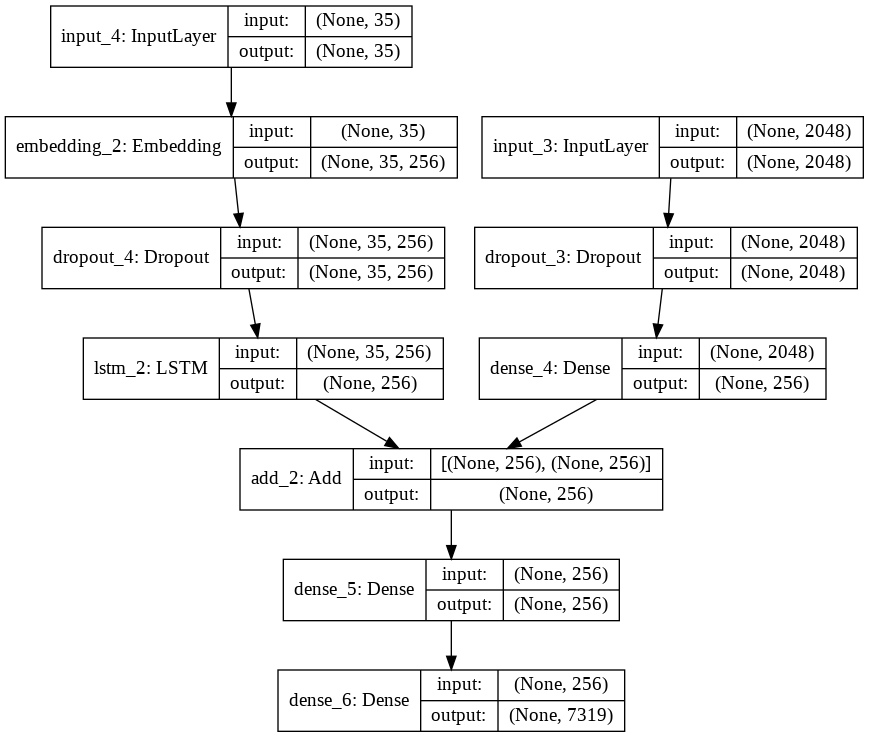

In [0]:
#--------------------------------------------------
# Define the model
#
# The model has three parts:
#    Photo Feature Extractor. This is the Image Classification model pre-trained on the ImageNet dataset. 
#                             We have pre-processed the images with this model, and will use the extracted features as input
#                             Expects input image features to be a vector of 4,096 elements. These are processed by a Dense 
#                             layer to produce a 256 element representation of the photo
#
#    Sequence Processor. This is a word embedding layer for handling the text input, followed by a LSTM layer.
#                        Expects input sequences with a pre-defined fixed length which are fed into an Embedding 
#                        layer that uses a mask to ignore padded values. This is followed by an LSTM layer with 256 
#                        memory units.
#
#                 Both the above two input models (ie. feature extractor and sequence processor) output a fixed-length vector. 
#                 Both input models use regularization in the form of 50% dropout. This is to reduce overfitting the 
#                 training dataset, as this model configuration learns very fast.
#
#    Predictor. Merges the vectors from both input models using an addition operation and then fed to a Dense layer followed
#               by a final output Dense layer to make a final prediction. It makes a softmax prediction over the entire 
#               output vocabulary for the next word in the sequence.
#--------------------------------------------------
from keras.utils import plot_model
def define_model(vocab_size, max_length, embedding_dim = 256):
	# feature extractor model
	inputs1 = Input(shape=(2048,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	
  # sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	
  # predictor model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)

	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam')

	# summarize model
	print(model.summary())
	plot_model(model, to_file='model.png', show_shapes=True)
	return model

# define the model
model = define_model(vocab_size, max_caption_words)
from IPython.display import Image
Image(filename='model.png')

In [0]:
#--------------------------------------------------
# Fit the model on the training dataset.
#
# Keras supports progressively loaded datasets by using the fit_generator() function on the model 
# to train with the previously defined data generator function.
#
# We train the model, running epochs manually and saving after each epoch
#--------------------------------------------------
epochs = 1
steps = len(training_dict)
for i in range(epochs):
	# create the data generator
	generator = data_generator(training_dict, training_image_features, tokenizer, max_caption_words, vocab_size)
	# fit for one epoch
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model.save('model_' + str(i) + '.h5')

Epoch 1/1
6000/6000 [==============================] - 760s 127ms/step - loss: 4.4878


In [0]:
#--------------------------------------------------
# Generate captions for an unseen image
#
# Start with the token ‘startseq‘, generate one word, then call the model recursively with generated words 
# as input until the end of sequence token is reached ‘endseq‘ or the maximum description length 
# is reached.
#
# Given a trained model and a pre-processed image as input, generates a textual caption
#--------------------------------------------------
def inference (model, image_feature, tokenizer, max_length):
  X1, X2, gen_caption_idxs = list(), list(), list()
  X1.append(image_feature)
  X2.append([])
  
  next_word_idx = tokenizer.word_index['startseq']
  end_word_idx = tokenizer.word_index['endseq']
  output_word_idx = -1
  while ((next_word_idx != end_word_idx) and (len(gen_caption_idxs) < max_length)):
    gen_caption_idxs.append (next_word_idx)
    inp = pad_text (gen_caption_idxs, max_length)
    X2[0] = inp

    output = model.predict([X1, X2], batch_size=1)
    
    # Convert the one-hot encoded word into a word index
    next_word_idx = np.argmax (output[0])

  gen_caption = tokenizer.sequences_to_texts([gen_caption_idxs[1:]])
  return (gen_caption[0])

man in red shirt is sitting on the beach ----------- startseq man in red shirt is sitting on the beach endseq


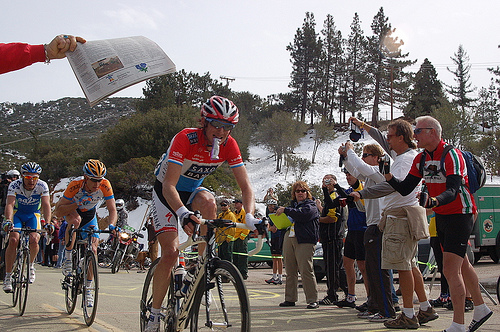

In [0]:
im_name = '3304712466_18cbdb85fe'
gen_text = inference (model, training_image_features[im_name], tokenizer, max_caption_words)
print (gen_text)

image_path = image_dir + im_name + ".jpg"
Image(filename=image_path)

**Next Steps**


*   Complete the inference step by adding pre-processing of brand new images
*   Train for 30 epochs
*   Implement Model Evaluation using BLEU scores
*   Add validation data to the fit-generation step
*   Reduce the vocabulary size to use only frequent words as done in the article
*   Use pre-defined Word Embeddings


**TO BE PROCESSED**

In [0]:
# !!!!!!!!!!!!!!!!!!!!!!
# This is a copy of the code for loading the training data. Modify it to load
# the validation data instead
# !!!!!!!!!!!!!!!!!!!!!!

validation_image_name_file = "dataset/Flickr_8k.devImages.txt"
test_image_name_file = "dataset/Flickr_8k.testImages.txt"

training_image_names = subset_image_name (training_image_name_file)
training_dict = subset_data_dict (image_dict, training_image_names)

training_image_features = extract_image_features (training_image_names, image_dir)

training_dump = "dataset/training_images.pkl"
save_image_features (training_image_features, training_dump)

# Load saved Image features from dump
training_image_features = load_image_features(training_dump, training_dict)
print('Photos: train=%d' % len(training_image_features))

#--------------------------------------------------
# Fit the model on the training dataset.
#
# The model learns fast and quickly overfits the training dataset. So, when the loss of the model 
# on the validation dataset improves at the end of an epoch, we will save the whole model to file.
# At the end of the run, we can then use the saved model with the best loss as our final model.
#
# To do this, we define a ModelCheckpoint in Keras, pecifying it to monitor the minimum loss on 
# the validation dataset and save the model to a file that has both the training and validation 
# loss in the filename.
#
# We can then specify the checkpoint in the call to model.fit() via the callbacks argument. We must 
# also specify the validation dataset in fit() via the validation_data argument.
#--------------------------------------------------

model_path = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


model.fit([X1train, X2train], ytrain, epochs=1, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

#--------------------------------------------------
#
# The input text is encoded as integers, which will be fed to a word embedding layer. The 
# image features will be fed directly to another part of the model. The model will output a 
# prediction, which will be a probability distribution over all words in the vocabulary. The 
# output data will therefore be a one-hot encoded version of each word, representing an 
# idealized probability distribution with 0 values at all word positions except the actual 
# word position, which has a value of 1.
#
#--------------------------------------------------